In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, Dataset,random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset

import pandas as pd
import shutil

import matplotlib.pyplot as plt

from torchvision import models
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score , f1_score

import os
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm
from torchvision import transforms

In [ ]:
import numpy as np
from PIL import Image
import random
import os
import csv

# สร้างโฟลเดอร์สำหรับเก็บรูปภาพ
output_folder = 'random_images'
os.makedirs(output_folder, exist_ok=True)

# ชื่อสีและค่า RGB ของสีต่างๆ
color_names = ['purple', 'blue', 'navy', 'green', 'yellow', 'orange', 'red']
colors = {
    'purple': (128, 0, 128),
    'blue': (0, 0, 255),
    'navy': (0, 0, 128),
    'green': (0, 255, 0),
    'yellow': (255, 255, 0),
    'orange': (255, 165, 0),
    'red': (255, 0, 0)
}

# ฟังก์ชันสร้างรูปภาพ
def create_image():
    # สุ่มสีสำหรับแต่ละส่วน
    color_top_left = random.choice(list(colors.values()))
    color_top_right = random.choice(list(colors.values()))
    color_bottom_left = random.choice(list(colors.values()))
    color_bottom_right = random.choice(list(colors.values()))

    # สร้าง array ขนาด 700x700x3 สำหรับรูปภาพ
    img_array = np.zeros((700, 700, 3), dtype=np.uint8)

    # แบ่งภาพออกเป็น 4 ส่วนและเติมสี
    img_array[:350, :350] = color_top_left       # ส่วนบนซ้าย
    img_array[:350, 350:] = color_top_right      # ส่วนบนขวา
    img_array[350:, :350] = color_bottom_left    # ส่วนล่างซ้าย
    img_array[350:, 350:] = color_bottom_right   # ส่วนล่างขวา

    return Image.fromarray(img_array), [color_top_left, color_top_right, color_bottom_left, color_bottom_right]

# ฟังก์ชันเช็กว่าสีที่เลือกอยู่ในภาพหรือไม่
def color_in_image(color_list, color_value):
    return int(any(np.array_equal(color_value, color) for color in color_list))

# สร้างไฟล์ CSV สำหรับภาพที่ 1 ถึง 150
csv_file_path_train = os.path.join(output_folder, 'image_colors_train.csv')
with open(csv_file_path_train, mode='w', newline='') as csvfile_train:
    csv_writer_train = csv.writer(csvfile_train)
    # เขียนหัว CSV (ชื่อสี + ชื่อไฟล์รูปภาพ)
    csv_writer_train.writerow(color_names + ['filename'])

    # สร้างภาพที่ 1 ถึง 150 และเขียนข้อมูลลงใน CSV
    for i in range(150):
        img, img_colors = create_image()
        filename = f'image_{i+1}.png'
        img.save(os.path.join(output_folder, filename))

        # ตรวจสอบแต่ละสีว่าอยู่ในภาพหรือไม่
        row = []
        for color_name in color_names:
            color_value = colors[color_name]
            row.append(color_in_image(img_colors, color_value))
        row.append(filename)

        # เขียนข้อมูลลง CSV
        csv_writer_train.writerow(row)

# สร้างไฟล์ CSV สำหรับภาพที่ 151 ถึง 200
csv_file_path_test = os.path.join(output_folder, 'image_colors_test.csv')
with open(csv_file_path_test, mode='w', newline='') as csvfile_test:
    csv_writer_test = csv.writer(csvfile_test)
    # เขียนหัว CSV (ชื่อสี + ชื่อไฟล์รูปภาพ)
    csv_writer_test.writerow(color_names + ['filename'])

    # สร้างภาพที่ 151 ถึง 200 และเขียนข้อมูลลงใน CSV
    for i in range(150, 200):
        img, img_colors = create_image()
        filename = f'image_{i+1}.png'
        img.save(os.path.join(output_folder, filename))

        # เว้นว่างคอลัมน์สี และใส่ชื่อไฟล์
        row = ['' for _ in color_names] + [filename]

        # เขียนข้อมูลลง CSV
        csv_writer_test.writerow(row)

print("สร้างรูปภาพ 200 รูป และไฟล์ CSV เสร็จสิ้น!")

สร้างรูปภาพ 200 รูป และไฟล์ CSV เสร็จสิ้น!


In [24]:
class PWINcustom(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.csv = pd.read_csv(csv_file)

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        img_id = self.csv.iloc[idx,-1]
        image = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        # Get color labels from the CSV (excluding the filename)
        labels = self.csv.iloc[idx, :-1].values.astype(int)
        p_3D,symmetric,food,person,nature,achitecture,animal = labels

        if self.transform:
            image = self.transform(image)
        return image, p_3D,symmetric,food,person,nature,achitecture,animal

In [27]:
aug_transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(contrast=0.1),
    transforms.RandomAffine(degrees=(0),
                            translate=(0.05, 0.05),
                            scale=(1.0, 1.0),
                            shear=0),
    transforms.ToTensor(), # Moved ToTensor before Normalize
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [28]:
root_dir = "/content/random_images"
csv = "/content/image_colors_train.csv"
dataset = PWINcustom(root_dir=root_dir, csv_file = csv ,transform=aug_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
image,p_3D,symmetric,food,person,nature,achitecture,animal  = next(iter(train_loader))

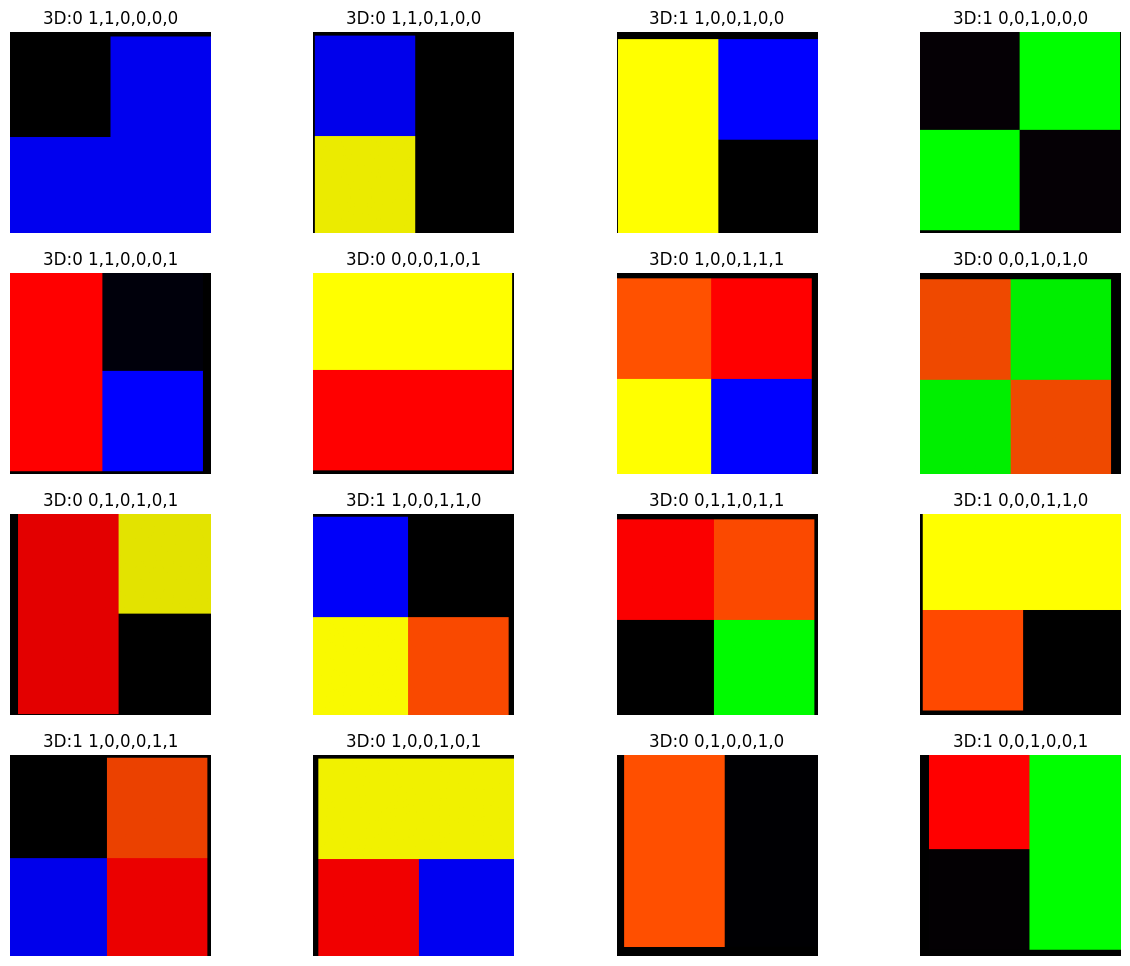

In [35]:
### START CODE HERE ###

image , p_3D,symmetric,food,person,nature,achitecture,animal  = next(iter(train_loader))
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.flatten()

for idx, (image , p_3D,symmetric,food,person,nature,achitecture,animal , ax) in enumerate(zip(image , p_3D,symmetric,food,person,nature,achitecture,animal, axes)):

    image = image.numpy().transpose((1,2,0))

    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f"3D:{p_3D} {symmetric},{food},{person},{nature},{achitecture},{animal}")

### END CODE HERE ###

In [31]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet(nn.Module):
    def __init__(self,
                 out=1,
                 h_dims_3D=[],
                 h_dims_symmetric=[],
                 h_dims_food=[],
                 h_dims_person=[],
                 h_dims_nature=[],
                 h_dims_achitecture=[],
                 h_dims_animal=[],
                 input_size=(3, 512, 512)):  # input_size is optional and unused for ResNet
        super(CustomResNet, self).__init__()

        self.resnet = models.resnet50(pretrained=True)

        # Freeze all layers except the fully connected layers
        for param in self.resnet.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer

        self.p_3D_classifier = self._create_classifier(in_features, h_dims_3D, out)
        self.symmetric_classifier = self._create_classifier(in_features, h_dims_symmetric, out)
        self.food_classifier = self._create_classifier(in_features, h_dims_food, out)
        self.person_classifier = self._create_classifier(in_features, h_dims_person, out)
        self.nature_classifier = self._create_classifier(in_features, h_dims_nature, out)
        self.achitecture_classifier = self._create_classifier(in_features, h_dims_achitecture, out)
        self.animal_classifier = self._create_classifier(in_features, h_dims_animal, out)

    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.3))
            in_features = hdim
        layers.append(nn.Linear(in_features, num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)  # ResNet forward pass up to the final layer

        p_3D_output = self.p_3D_classifier(x)
        symmetric_output = self.symmetric_classifier(x)
        food_output = self.food_classifier(x)
        person_output = self.person_classifier(x)
        nature_output = self.nature_classifier(x)
        achitecture_output = self.achitecture_classifier(x)
        animal_output = self.animal_classifier(x)

        return p_3D_output, symmetric_output, food_output, person_output, nature_output, achitecture_output, animal_output

In [52]:
def train(model,
          optimizer,
          train_loader,
          test_loader,
          epochs=10,
          beta=1,
          checkpoint_path=None,
          device='cpu'):
    global best_score
    model = model.to(device)
    print("Training on", device)

    for epoch in range(epochs):
        model.train()

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        l1_lambda = 1e-5

        bce_loss = nn.BCELoss()

        train_bar = tqdm(train_loader,desc=f'🚀Training Epoch [{epoch+1}/{epochs}]',unit='batch')

        for batch_idx, (data, p_3D_target, symmetric_target, food_target, person_target, nature_target, achitecture_target, animal_target) in enumerate(train_bar):
            data, p_3D_target, symmetric_target, food_target, person_target, nature_target, achitecture_target, animal_target = data.to(device), p_3D_target.to(device), symmetric_target.to(device), food_target.to(device), person_target.to(device), nature_target.to(device), achitecture_target.to(device), animal_target.to(device)

            # แปลงประเภทข้อมูลเป็น float
            p_3D_target = p_3D_target.float().unsqueeze(1)  # เพิ่มมิติที่ 1
            symmetric_target = symmetric_target.float().unsqueeze(1)
            food_target = food_target.float().unsqueeze(1)
            person_target = person_target.float().unsqueeze(1)
            nature_target = nature_target.float().unsqueeze(1)
            achitecture_target = achitecture_target.float().unsqueeze(1)
            animal_target = animal_target.float().unsqueeze(1)

            optimizer.zero_grad()

            p_3D_output, symmetric_output, food_output, person_output, nature_output, achitecture_output, animal_output = model(data)

            # Apply sigmoid to outputs
            p_3D_output = torch.sigmoid(p_3D_output)
            symmetric_output = torch.sigmoid(symmetric_output)
            food_output = torch.sigmoid(food_output)
            person_output = torch.sigmoid(person_output)
            nature_output = torch.sigmoid(nature_output)
            achitecture_output = torch.sigmoid(achitecture_output)
            animal_output = torch.sigmoid(animal_output)

            loss_3D = bce_loss(p_3D_output, p_3D_target)
            loss_symmetric = bce_loss(symmetric_output, symmetric_target)
            loss_food = bce_loss(food_output, food_target)
            loss_person = bce_loss(person_output, person_target)
            loss_nature = bce_loss(nature_output, nature_target)
            loss_achitecture = bce_loss(achitecture_output, achitecture_target)
            loss_animal = bce_loss(animal_output, animal_target)

            loss = loss_3D + loss_symmetric + loss_food + loss_person + loss_nature + loss_achitecture + loss_animal

            loss.backward()
            optimizer.step()

            train_bar.set_postfix(loss=loss.item())

        model.eval()

        correct_3D, correct_symmetric, correct_food, correct_person, correct_nature, correct_achitecture, correct_animal = 0, 0, 0, 0, 0, 0, 0
        test_loss_3D, test_loss_symmetric, test_loss_food, test_loss_person, test_loss_nature, test_loss_achitecture, test_loss_animal = 0, 0, 0, 0, 0, 0, 0

        all_3D_preds, all_3D_targets = [], []
        all_symmetric_preds, all_symmetric_targets = [], []
        all_food_preds, all_food_targets = [], []
        all_person_preds, all_person_targets = [], []
        all_nature_preds, all_nature_targets = [], []
        all_achitecture_preds, all_achitecture_targets = [], []
        all_animal_preds, all_animal_targets = [], []

        with torch.no_grad():
            test_bar = tqdm(test_loader,
                            desc=f"Testing Epoch [{epoch+1}/{epochs}]",unit='batch')

            for data, p_3D_target, symmetric_target, food_target, person_target, nature_target, achitecture_target, animal_target in test_bar:
                data, p_3D_target, symmetric_target, food_target, person_target, nature_target, achitecture_target, animal_target = data.to(device), p_3D_target.to(device), symmetric_target.to(device), food_target.to(device), person_target.to(device), nature_target.to(device), achitecture_target.to(device), animal_target.to(device)

                # แปลงประเภทข้อมูลเป็น float
                p_3D_target = p_3D_target.float().unsqueeze(1)  # เพิ่มมิติที่ 1
                symmetric_target = symmetric_target.float().unsqueeze(1)
                food_target = food_target.float().unsqueeze(1)
                person_target = person_target.float().unsqueeze(1)
                nature_target = nature_target.float().unsqueeze(1)
                achitecture_target = achitecture_target.float().unsqueeze(1)
                animal_target = animal_target.float().unsqueeze(1)

                p_3D_output, symmetric_output, food_output, person_output, nature_output, achitecture_output, animal_output = model(data)

                # Apply sigmoid to outputs
                p_3D_output = torch.sigmoid(p_3D_output)
                symmetric_output = torch.sigmoid(symmetric_output)
                food_output = torch.sigmoid(food_output)
                person_output = torch.sigmoid(person_output)
                nature_output = torch.sigmoid(nature_output)
                achitecture_output = torch.sigmoid(achitecture_output)
                animal_output = torch.sigmoid(animal_output)

                test_loss_3D += bce_loss(p_3D_output, p_3D_target).item()
                test_loss_symmetric += bce_loss(symmetric_output, symmetric_target).item()
                test_loss_food += bce_loss(food_output, food_target).item()
                test_loss_person += bce_loss(person_output, person_target).item()
                test_loss_nature += bce_loss(nature_output, nature_target).item()
                test_loss_achitecture += bce_loss(achitecture_output, achitecture_target).item()
                test_loss_animal += bce_loss(animal_output, animal_target).item()

                p_3D_pred = torch.round(p_3D_output)
                symmetric_pred = torch.round(symmetric_output)
                food_pred = torch.round(food_output)
                person_pred = torch.round(person_output)
                nature_pred = torch.round(nature_output)
                achitecture_pred = torch.round(achitecture_output)
                animal_pred = torch.round(animal_output)

                correct_3D += p_3D_pred.eq(p_3D_target.view_as(p_3D_pred)).sum().item()
                correct_symmetric += symmetric_pred.eq(symmetric_target.view_as(symmetric_pred)).sum().item()
                correct_food += food_pred.eq(food_target.view_as(food_pred)).sum().item()
                correct_person += person_pred.eq(person_target.view_as(person_pred)).sum().item()
                correct_nature += nature_pred.eq(nature_target.view_as(nature_pred)).sum().item()
                correct_achitecture += achitecture_pred.eq(achitecture_target.view_as(achitecture_pred)).sum().item()
                correct_animal += animal_pred.eq(animal_target.view_as(animal_pred)).sum().item()

                all_3D_preds.extend(p_3D_pred.cpu().numpy())
                all_3D_targets.extend(p_3D_target.cpu().numpy())
                all_symmetric_preds.extend(symmetric_pred.cpu().numpy())
                all_symmetric_targets.extend(symmetric_target.cpu().numpy())
                all_food_preds.extend(food_pred.cpu().numpy())
                all_food_targets.extend(food_target.cpu().numpy())
                all_person_preds.extend(person_pred.cpu().numpy())
                all_person_targets.extend(person_target.cpu().numpy())
                all_nature_preds.extend(nature_pred.cpu().numpy())
                all_nature_targets.extend(nature_target.cpu().numpy())
                all_achitecture_preds.extend(achitecture_pred.cpu().numpy())
                all_achitecture_targets.extend(achitecture_target.cpu().numpy())
                all_animal_preds.extend(animal_pred.cpu().numpy())
                all_animal_targets.extend(animal_target.cpu().numpy())

            test_loss_3D /= len(test_loader.dataset)
            test_loss_symmetric /= len(test_loader.dataset)
            test_loss_food /= len(test_loader.dataset)
            test_loss_person /= len(test_loader.dataset)
            test_loss_nature /= len(test_loader.dataset)
            test_loss_achitecture /= len(test_loader.dataset)
            test_loss_animal /= len(test_loader.dataset)

            accuracy_3D = 100. * correct_3D / len(test_loader.dataset)
            accuracy_symmetric = 100. * correct_symmetric / len(test_loader.dataset)
            accuracy_food = 100. * correct_food / len(test_loader.dataset)
            accuracy_person = 100. * correct_person / len(test_loader.dataset)
            accuracy_nature = 100. * correct_nature / len(test_loader.dataset)
            accuracy_achitecture = 100. * correct_achitecture / len(test_loader.dataset)
            accuracy_animal = 100. * correct_animal / len(test_loader.dataset)

            f1_3D = f1_score(all_3D_targets, all_3D_preds, average='macro')
            f1_symmetric = f1_score(all_symmetric_targets, all_symmetric_preds, average='macro')
            f1_food = f1_score(all_food_targets, all_food_preds, average='macro')
            f1_person = f1_score(all_person_targets, all_person_preds, average='macro')
            f1_nature = f1_score(all_nature_targets, all_nature_preds, average='macro')
            f1_achitecture = f1_score(all_achitecture_targets, all_achitecture_preds, average='macro')
            f1_animal = f1_score(all_animal_targets, all_animal_preds, average='macro')

            score = (accuracy_3D + accuracy_symmetric + accuracy_food + accuracy_person + accuracy_nature + accuracy_achitecture + accuracy_animal) / 7
            total_f1 = (f1_3D+f1_symmetric+f1_food+f1_person+f1_nature+f1_achitecture+f1_animal)/7

            if score > best_score:
                best_score = score
                if checkpoint_path is not None:
                    torch.save(model.state_dict(), checkpoint_path)

            print(f'Epoch: {epoch+1}/{epochs}')
            print(f'Test Loss - 3D: {test_loss_3D:.4f}, Symmetric: {test_loss_symmetric:.4f}, Food: {test_loss_food:.4f}, Person: {test_loss_person:.4f}, Nature: {test_loss_nature:.4f}, Achitecture: {test_loss_achitecture:.4f}, Animal: {test_loss_animal:.4f}')
            print(f'Accuracy - 3D: {accuracy_3D:.2f}%, Symmetric: {accuracy_symmetric:.2f}%, Food: {accuracy_food:.2f}%, Person: {accuracy_person:.2f}%, Nature: {accuracy_nature:.2f}%, Achitecture: {accuracy_achitecture:.2f}%, Animal: {accuracy_animal:.2f}%')
            print(f'F1 Score - 3D: {f1_3D:.4f}, Symmetric: {f1_symmetric:.4f}, Food: {f1_food:.4f}, Person: {f1_person:.4f}, Nature: {f1_nature:.4f}, Achitecture: {f1_achitecture:.4f}, Animal: {f1_animal:.4f}')
            print(f'Accurancay Score: {score:.4f}\n')
            print(f'F1 Score: {total_f1:.4f}\n')
        scheduler.step()


In [53]:
model = CustomResNet(h_dims_3D=[512,512],h_dims_symmetric=[512,512],h_dims_food=[512,512],h_dims_person=[512,512],h_dims_nature=[512,512],h_dims_achitecture=[512,512],h_dims_animal=[512,512])
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=5,
      beta=2,
      checkpoint_path="path.pth",
      device=device)

print(f"Best Score is {best_score:.4f}")

Training on cpu


Testing Epoch [1/5]: 100%|██████████| 2/2 [00:05<00:00,  2.68s/batch]


Epoch: 1/5
Test Loss - 3D: 0.0461, Symmetric: 0.0462, Food: 0.0461, Person: 0.0445, Nature: 0.0467, Achitecture: 0.0461, Animal: 0.0459
Accuracy - 3D: 60.00%, Symmetric: 50.00%, Food: 60.00%, Person: 70.00%, Nature: 43.33%, Achitecture: 56.67%, Animal: 56.67%
F1 Score - 3D: 0.5833, Symmetric: 0.3333, Food: 0.3750, Person: 0.4118, Nature: 0.3023, Achitecture: 0.4994, Animal: 0.3617
Average Score: 56.6667



Testing Epoch [2/5]: 100%|██████████| 2/2 [00:06<00:00,  3.19s/batch]


Epoch: 2/5
Test Loss - 3D: 0.0462, Symmetric: 0.0462, Food: 0.0460, Person: 0.0443, Nature: 0.0468, Achitecture: 0.0459, Animal: 0.0458
Accuracy - 3D: 53.33%, Symmetric: 50.00%, Food: 56.67%, Person: 70.00%, Nature: 43.33%, Achitecture: 56.67%, Animal: 56.67%
F1 Score - 3D: 0.4976, Symmetric: 0.3333, Food: 0.3617, Person: 0.4118, Nature: 0.3023, Achitecture: 0.3617, Animal: 0.3617
Average Score: 55.2381



Testing Epoch [3/5]: 100%|██████████| 2/2 [00:05<00:00,  2.66s/batch]


Epoch: 3/5
Test Loss - 3D: 0.0458, Symmetric: 0.0457, Food: 0.0461, Person: 0.0442, Nature: 0.0469, Achitecture: 0.0456, Animal: 0.0452
Accuracy - 3D: 66.67%, Symmetric: 50.00%, Food: 56.67%, Person: 70.00%, Nature: 43.33%, Achitecture: 56.67%, Animal: 56.67%
F1 Score - 3D: 0.6411, Symmetric: 0.3333, Food: 0.3617, Person: 0.4118, Nature: 0.3023, Achitecture: 0.3617, Animal: 0.3617
Average Score: 57.1429



Testing Epoch [4/5]: 100%|██████████| 2/2 [00:08<00:00,  4.21s/batch]


Epoch: 4/5
Test Loss - 3D: 0.0457, Symmetric: 0.0453, Food: 0.0459, Person: 0.0438, Nature: 0.0468, Achitecture: 0.0456, Animal: 0.0453
Accuracy - 3D: 66.67%, Symmetric: 50.00%, Food: 60.00%, Person: 70.00%, Nature: 43.33%, Achitecture: 56.67%, Animal: 56.67%
F1 Score - 3D: 0.6652, Symmetric: 0.3333, Food: 0.3750, Person: 0.4118, Nature: 0.3023, Achitecture: 0.3617, Animal: 0.3617
Average Score: 57.6190



Testing Epoch [5/5]: 100%|██████████| 2/2 [00:07<00:00,  3.61s/batch]


Epoch: 5/5
Test Loss - 3D: 0.0455, Symmetric: 0.0449, Food: 0.0456, Person: 0.0433, Nature: 0.0470, Achitecture: 0.0455, Animal: 0.0450
Accuracy - 3D: 76.67%, Symmetric: 50.00%, Food: 60.00%, Person: 70.00%, Nature: 43.33%, Achitecture: 56.67%, Animal: 56.67%
F1 Score - 3D: 0.7600, Symmetric: 0.3333, Food: 0.3750, Person: 0.4118, Nature: 0.3023, Achitecture: 0.3617, Animal: 0.3617
Average Score: 59.0476

Best Score is 59.0476


In [56]:
model = CustomResNet(h_dims_3D=[512,512],h_dims_symmetric=[512,512],h_dims_food=[512,512],h_dims_person=[512,512],h_dims_nature=[512,512],h_dims_achitecture=[512,512],h_dims_animal=[512,512])
model.load_state_dict(torch.load("/content/path.pth"))

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

file_names, p_3D_preds, symmetric_preds, food_preds, person_preds, nature_preds, achitecture_preds, animal_preds = [], [], [], [], [], [], [], []

aug_transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(contrast=0.1),
    transforms.RandomAffine(degrees=(0),
                            translate=(0.05, 0.05),
                            scale=(1.0, 1.0),
                            shear=0),
    transforms.ToTensor(), # Moved ToTensor before Normalize
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

csv_file = '/content/image_colors_test.csv'
df = pd.read_csv(csv_file)

file_paths_from_csv = df.iloc[:, 0]

with torch.no_grad():
    submit_bar = tqdm(file_paths_from_csv, desc=f'📄 Submitting...', unit='image')
    for img_path in submit_bar:

        if not os.path.exists(img_path):
            print(f"File {img_path} does not exist.")
            continue
        image = Image.open(img_path).convert('RGB')
        image = aug_transform(image)
        image = image.unsqueeze(0).to(device)

        p_3D_output, symmetric_output, food_output, person_output, nature_output, achitecture_output, animal_output  = model(image)

        p_3D_pred = p_3D_output.argmax(dim=1, keepdim=True).item()
        p_3D_preds.append(p_3D_pred)

        symmetric_pred = symmetric_output.argmax(dim=1, keepdim=True).item()
        symmetric_preds.append(symmetric_pred)

        food_pred = food_output.argmax(dim=1, keepdim=True).item()
        food_preds.append(food_pred)

        person_pred = person_output.argmax(dim=1, keepdim=True).item()
        person_preds.append(person_pred)

        nature_pred = nature_output.argmax(dim=1, keepdim=True).item()
        nature_preds.append(nature_pred)

        achitecture_pred = achitecture_output.argmax(dim=1, keepdim=True).item()
        achitecture_preds.append(achitecture_pred)

        animal_pred = animal_output.argmax(dim=1, keepdim=True).item()
        animal_preds.append(animal_pred)

        file_name = os.path.basename(img_path)
        file_names.append(f"images/{file_name}")

data = list(zip(file_names,p_3D_preds,symmetric_preds,food_preds,nature_preds,achitecture_preds,animal_preds))
submission_df = pd.DataFrame(data, columns=['image_path', 'font', 'font_size', 'color'])

output_path = 'sUbmiss.csv'
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-56-205bd714890c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

TypeError: stat: path should be string, bytes, os.PathLike or integer, not float